# Multiperiod Reports by Quarter in Beancount
If you've ever used [hledger](https://hledger.org/), you might like its ability to produce nice reports. One of the reports' feature is the table structure, where rows are accounts and columns are weeks, months, quarters or years. Looking at earnings and spendings as a function of time can give you more insights about your finances.

However, if you are using [beancount](http://furius.ca/beancount/), this feature is not yet supported in the command line interface. You need to use [fava](https://github.com/beancount/fava), an awesome web-interface for beancount, which has a graph drawing capability as described in this tutorial. fava is not ideal and sometimes you might need more custom reports than the ones available in fava.

This notebook provides methodology and tools to:
- Process BQL query's output using Pandas library
- Generate quarterly totals (multiperiod reports by quarter) by pivoting a table
- Aggregate values at different account levels for the provided account hierarchy
- Draw treemap plots of expenses for all time period

Details are in [this blog post](https://www.isabekov.pro/multiperiod-hledger-style-reports-in-beancount-pivoting-a-table/).

In [1]:
from beancount.loader import load_file
from beancount.query.query import run_query
from beancount.query.numberify import numberify_results
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_column', 15)
pd.set_option('display.max_rows', 5)
pd.set_option("max_rows", 5)
pd.set_option('display.max_seq_items', 5)
pd.set_option('display.max_colwidth', 50000)
pd.set_option('display.width', 500)
#pd.set_option('display.expand_frame_repr', True)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('precision', 2)
#pd.set_option('expand_frame_repr', True)
import squarify
from matplotlib import pyplot as plt
font = {'weight' : 'normal',
        'size'   : 12}
plt.rc('font', **font)
plt.rcParams["figure.figsize"] = (15, 5)

## Create and Load an Example Beancount Journal File

In [2]:
FileName = "example.beancount"
if not os.path.isfile(FileName):
    os.system("bean-example > {}".format(FileName))      
    
entries, _, opts = load_file(FileName)
currency = opts["operating_currency"][0]
# Main currency
currency

'USD'

## Investigating a Transaction

In [3]:
# Not all of the entries are transactions
len(entries)

1517

## Executing a BQL Query

In [4]:
cols, rows = run_query(entries, opts, 
                       "SELECT   account,   YEAR(date) AS year,\
                                 MONTH(date) as month,\
                                 SUM(convert(position, '{}', date)) AS amount\
                        WHERE    account ~ 'Expenses'\
                        OR       account ~ 'Income'\
                        GROUP BY account, year, month\
                        ORDER BY account, year, month".format(currency)
                      )
cols

[('account', str),
 ('year', int),
 ('month', int),
 ('amount', beancount.core.inventory.Inventory)]

In [5]:
rows[:3]

[ResultRow(account='Expenses:Financial:Commissions', year=2019, month=10, amount=(26.85 USD)),
 ResultRow(account='Expenses:Financial:Commissions', year=2019, month=12, amount=(17.90 USD)),
 ResultRow(account='Expenses:Financial:Commissions', year=2020, month=4, amount=(17.90 USD))]

In [6]:
cols, rows = numberify_results(cols, rows)
cols

[('account', str),
 ('year', int),
 ('month', int),
 ('amount (USD)', decimal.Decimal),
 ('amount (VACHR)', decimal.Decimal),
 ('amount (IRAUSD)', decimal.Decimal)]

In [7]:
rows[:3]

[['Expenses:Financial:Commissions', 2019, 10, Decimal('26.85'), None, None],
 ['Expenses:Financial:Commissions', 2019, 12, Decimal('17.90'), None, None],
 ['Expenses:Financial:Commissions', 2020, 4, Decimal('17.90'), None, None]]

## Converting Result Rows to a Pandas Dataframe

In [8]:
df = pd.DataFrame(rows, columns=[k[0] for k in cols])
df.head()

,account,year,month,amount (USD),amount (VACHR),amount (IRAUSD)
0,Expenses:Financial:Commissions,2019,10,26.85,None,None
1,Expenses:Financial:Commissions,2019,12,17.90,None,None
2,Expenses:Financial:Commissions,2020,4,17.90,None,None
3,Expenses:Financial:Commissions,2020,6,26.85,None,None
4,Expenses:Financial:Commissions,2020,8,44.75,None,None


In [9]:
df.rename(columns={"account": "Account", "year":"Year", "month": "Month", "amount ({})".format(currency): "Amount ({})".format(currency)}, inplace=True)
df.dtypes

Account            object
Year                int64
                    ...  
amount (VACHR)     object
amount (IRAUSD)    object
Length: 6, dtype: object

In [10]:
df = df.astype({"Account": str, "Year": int, "Month": int, "Amount ({})".format(currency): np.float})
df = df[["Account", "Year", "Month", "Amount ({})".format(currency)]].fillna(0)
df.head()

,Account,Year,Month,Amount (USD)
0,Expenses:Financial:Commissions,2019,10,26.85
1,Expenses:Financial:Commissions,2019,12,17.90
2,Expenses:Financial:Commissions,2020,4,17.90
3,Expenses:Financial:Commissions,2020,6,26.85
4,Expenses:Financial:Commissions,2020,8,44.75


In [11]:
df["YearMonth"] = df.apply(lambda x: "{}-{:0>2d}".format(x["Year"], x["Month"]),axis=1)
df = df[["Account", "YearMonth", "Amount ({})".format(currency)]]
df.head()

,Account,YearMonth,Amount (USD)
0,Expenses:Financial:Commissions,2019-10,26.85
1,Expenses:Financial:Commissions,2019-12,17.90
2,Expenses:Financial:Commissions,2020-04,17.90
3,Expenses:Financial:Commissions,2020-06,26.85
4,Expenses:Financial:Commissions,2020-08,44.75


In [12]:
print(df.__repr__())

                            Account YearMonth  Amount (USD)
0    Expenses:Financial:Commissions   2019-10         26.85
1    Expenses:Financial:Commissions   2019-12         17.90
..                              ...       ...           ...
561       Income:US:Hoogle:Vacation   2020-11          0.00
562       Income:US:Hoogle:Vacation   2020-12          0.00

[563 rows x 3 columns]


In [13]:
print(df.head().reset_index().to_markdown())

|    |   index | Account                        | YearMonth   |   Amount (USD) |
|---:|--------:|:-------------------------------|:------------|---------------:|
|  0 |       0 | Expenses:Financial:Commissions | 2019-10     |          26.85 |
|  1 |       1 | Expenses:Financial:Commissions | 2019-12     |          17.9  |
|  2 |       2 | Expenses:Financial:Commissions | 2020-04     |          17.9  |
|  3 |       3 | Expenses:Financial:Commissions | 2020-06     |          26.85 |
|  4 |       4 | Expenses:Financial:Commissions | 2020-08     |          44.75 |


In [14]:
df.index = pd.to_datetime(df["YearMonth"], format='%Y-%m') + pd.offsets.MonthEnd(0)
df.drop(columns="YearMonth", inplace=True)
df.head()

,Account,Amount (USD)
YearMonth,,
2019-10-31,Expenses:Financial:Commissions,26.85
2019-12-31,Expenses:Financial:Commissions,17.90
2020-04-30,Expenses:Financial:Commissions,17.90
2020-06-30,Expenses:Financial:Commissions,26.85
2020-08-31,Expenses:Financial:Commissions,44.75


In [15]:
# Aggregate at month level
df = df.groupby(["Account", pd.Grouper(freq='Q')]).sum()
df.head(20)

Amount (USD)
Account                        YearMonth               
Expenses:Financial:Commissions 2019-12-31         44.75
                               2020-06-30         44.75
...                                                 ...
Expenses:Food:Groceries        2019-12-31        729.28
                               2020-03-31        761.37

[20 rows x 1 columns]

## Pivoting a Table by Quarter

In [16]:
df = df.pivot_table(index="Account", columns=df.index.get_level_values(1).map(lambda s: s.strftime('%Y-%m')).astype('period[Q]').strftime('%F-Q%q')).fillna(0).reset_index()
df.head()

Account Amount (USD)                                                        
YearMonth                                      2019-Q1 2019-Q2 2019-Q3 2019-Q4 2020-Q1 2020-Q2 2020-Q3 2020-Q4
0          Expenses:Financial:Commissions         0.00    0.00    0.00   44.75    0.00   44.75   53.70  143.20
1                 Expenses:Financial:Fees        12.00   12.00   12.00   12.00   12.00   12.00   12.00   12.00
2                   Expenses:Food:Alcohol         0.00    0.00    0.00    0.00   26.34    0.00    0.00    0.00
3                    Expenses:Food:Coffee         0.00    0.00    0.00    0.00   31.72    0.00   34.75    0.00
4                 Expenses:Food:Groceries       582.79  473.92  449.42  729.28  761.37  459.74  526.52  471.39

In [17]:
dfm = df.copy()
dfm.columns = dfm.columns.droplevel(level=0)
dfm.head()

YearMonth,,2019-Q1,2019-Q2,2019-Q3,2019-Q4,2020-Q1,2020-Q2,2020-Q3,2020-Q4
0,Expenses:Financial:Commissions,0.00,0.00,0.00,44.75,0.00,44.75,53.70,143.20
1,Expenses:Financial:Fees,12.00,12.00,12.00,12.00,12.00,12.00,12.00,12.00
2,Expenses:Food:Alcohol,0.00,0.00,0.00,0.00,26.34,0.00,0.00,0.00
3,Expenses:Food:Coffee,0.00,0.00,0.00,0.00,31.72,0.00,34.75,0.00
4,Expenses:Food:Groceries,582.79,473.92,449.42,729.28,761.37,459.74,526.52,471.39


In [18]:
print(dfm.head().to_markdown())

|    |                                |   2019-Q1 |   2019-Q2 |   2019-Q3 |   2019-Q4 |   2020-Q1 |   2020-Q2 |   2020-Q3 |   2020-Q4 |
|---:|:-------------------------------|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|
|  0 | Expenses:Financial:Commissions |      0    |      0    |      0    |     44.75 |      0    |     44.75 |     53.7  |    143.2  |
|  1 | Expenses:Financial:Fees        |     12    |     12    |     12    |     12    |     12    |     12    |     12    |     12    |
|  2 | Expenses:Food:Alcohol          |      0    |      0    |      0    |      0    |     26.34 |      0    |      0    |      0    |
|  3 | Expenses:Food:Coffee           |      0    |      0    |      0    |      0    |     31.72 |      0    |     34.75 |      0    |
|  4 | Expenses:Food:Groceries        |    582.79 |    473.92 |    449.42 |    729.28 |    761.37 |    459.74 |    526.52 |    471.39 |


## Creating Multi-Level Accounts

In [19]:
n_levels = df["Account"].str.count(":").max() + 1
n_levels

6

In [20]:
cols = ["Account_L{}".format(k) for k in range(n_levels)]
cols

['Account_L0',
 'Account_L1',
 'Account_L2',
 'Account_L3',
 'Account_L4',
 'Account_L5']

In [21]:
df[cols] = df["Account"].str.split(':', n_levels - 1, expand=True)
df = df.fillna('').drop(columns="Account", level=0).set_index(cols)
df.head()

Amount (USD)                                                        
YearMonth                                                               2019-Q1 2019-Q2 2019-Q3 2019-Q4 2020-Q1 2020-Q2 2020-Q3 2020-Q4
Account_L0 Account_L1 Account_L2  Account_L3 Account_L4 Account_L5                                                                     
Expenses   Financial  Commissions                                          0.00    0.00    0.00   44.75    0.00   44.75   53.70  143.20
                      Fees                                                12.00   12.00   12.00   12.00   12.00   12.00   12.00   12.00
           Food       Alcohol                                              0.00    0.00    0.00    0.00   26.34    0.00    0.00    0.00
                      Coffee                                               0.00    0.00    0.00    0.00   31.72    0.00   34.75    0.00
                      Groceries                                          582.79  473.92  449.42  729.28  761.37  459.74  526.52  471.39

In [22]:
dfm = df.copy()
dfm.columns = dfm.columns.droplevel(level=0)
dfm.head()

YearMonth                                                           2019-Q1  2019-Q2  2019-Q3  2019-Q4  2020-Q1  2020-Q2  2020-Q3  2020-Q4
Account_L0 Account_L1 Account_L2  Account_L3 Account_L4 Account_L5                                                                        
Expenses   Financial  Commissions                                      0.00     0.00     0.00    44.75     0.00    44.75    53.70   143.20
                      Fees                                            12.00    12.00    12.00    12.00    12.00    12.00    12.00    12.00
           Food       Alcohol                                          0.00     0.00     0.00     0.00    26.34     0.00     0.00     0.00
                      Coffee                                           0.00     0.00     0.00     0.00    31.72     0.00    34.75     0.00
                      Groceries                                      582.79   473.92   449.42   729.28   761.37   459.74   526.52   471.39

In [23]:
print(dfm.reset_index().head().to_markdown())

|    | Account_L0   | Account_L1   | Account_L2   | Account_L3   | Account_L4   | Account_L5   |   2019-Q1 |   2019-Q2 |   2019-Q3 |   2019-Q4 |   2020-Q1 |   2020-Q2 |   2020-Q3 |   2020-Q4 |
|---:|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|
|  0 | Expenses     | Financial    | Commissions  |              |              |              |      0    |      0    |      0    |     44.75 |      0    |     44.75 |     53.7  |    143.2  |
|  1 | Expenses     | Financial    | Fees         |              |              |              |     12    |     12    |     12    |     12    |     12    |     12    |     12    |     12    |
|  2 | Expenses     | Food         | Alcohol      |              |              |              |      0    |      0    |      0    |      0    |     26.34 |      0    |      0    |      0    |
|  3 | Expenses     | Food         

## Aggregation at Different Account Levels

In [24]:
df_L1 = df.groupby(["Account_L0", "Account_L1"]).sum()
df_L1.style.set_table_styles(
[{'selector': 'tr:hover',
  'props': [('background-color', 'yellow')]}]
)

In [25]:
dfm = df_L1.copy()
dfm.columns = dfm.columns.droplevel(level=0)
dfm.head()

YearMonth               2019-Q1   2019-Q2   2019-Q3   2019-Q4   2020-Q1   2020-Q2   2020-Q3   2020-Q4
Account_L0 Account_L1                                                                                
Expenses   Financial      12.00     12.00     12.00     56.75     12.00     56.75     65.70    155.20
           Food         1363.37   1474.85   1511.20   1658.43   1994.22   1539.86   2041.25   1441.73
           Health        678.30    581.40    678.30    581.40    678.30    581.40    678.30    678.30
           Home         7808.39   7855.83   7787.99   7822.96   7832.48   7818.26   7854.17   7816.34
           Taxes       13945.40  11953.20  13945.40  11633.20  14593.39  11953.20  13945.40  13343.86

In [26]:
print(dfm.reset_index().head().to_markdown())

|    | Account_L0   | Account_L1   |   2019-Q1 |   2019-Q2 |   2019-Q3 |   2019-Q4 |   2020-Q1 |   2020-Q2 |   2020-Q3 |   2020-Q4 |
|---:|:-------------|:-------------|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|
|  0 | Expenses     | Financial    |     12    |     12    |     12    |     56.75 |     12    |     56.75 |     65.7  |    155.2  |
|  1 | Expenses     | Food         |   1363.37 |   1474.85 |   1511.2  |   1658.43 |   1994.22 |   1539.86 |   2041.25 |   1441.73 |
|  2 | Expenses     | Health       |    678.3  |    581.4  |    678.3  |    581.4  |    678.3  |    581.4  |    678.3  |    678.3  |
|  3 | Expenses     | Home         |   7808.39 |   7855.83 |   7787.99 |   7822.96 |   7832.48 |   7818.26 |   7854.17 |   7816.34 |
|  4 | Expenses     | Taxes        |  13945.4  |  11953.2  |  13945.4  |  11633.2  |  14593.4  |  11953.2  |  13945.4  |  13343.9  |


In [27]:
df_L0 = df.groupby(["Account_L0"]).sum()
df_L0.style.set_table_styles(
[{'selector': 'tr:hover',
  'props': [('background-color', 'yellow')]}]
)

In [28]:
dfm = df_L0.copy()
dfm.columns = dfm.columns.droplevel(level=0)
dfm.head()

YearMonth,2019-Q1,2019-Q2,2019-Q3,2019-Q4,2020-Q1,2020-Q2,2020-Q3,2020-Q4
Account_L0,,,,,,,,
Expenses,24047.46,22237.28,24294.89,22232.74,25470.39,22309.47,24944.82,23795.43
Income,-36677.90,-31438.20,-33927.90,-27869.27,-36708.97,-31141.12,-34566.94,-32656.45


In [29]:
print(dfm.reset_index().head().to_markdown())

|    | Account_L0   |   2019-Q1 |   2019-Q2 |   2019-Q3 |   2019-Q4 |   2020-Q1 |   2020-Q2 |   2020-Q3 |   2020-Q4 |
|---:|:-------------|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|
|  0 | Expenses     |   24047.5 |   22237.3 |   24294.9 |   22232.7 |   25470.4 |   22309.5 |   24944.8 |   23795.4 |
|  1 | Income       |  -36677.9 |  -31438.2 |  -33927.9 |  -27869.3 |  -36709   |  -31141.1 |  -34566.9 |  -32656.5 |


In [30]:
# Net income
-df_L0.sum(axis=0).to_frame().rename(columns={0: "Net income"}).transpose()

Amount (USD)                                                                
YearMonth       2019-Q1  2019-Q2  2019-Q3  2019-Q4   2020-Q1  2020-Q2  2020-Q3  2020-Q4
Net income     12630.44  9200.92  9633.01  5636.53  11238.58  8831.65  9622.12  8861.02

In [31]:
# Invert the sign of the "Income" account. Negative income is counter-intuitive.
df_L0.loc["Income"] = -df_L0.loc["Income"]
df_L0 = df_L0.transpose().reset_index()
df_L0

Account_L0,level_0,YearMonth,Expenses,Income
0,Amount (USD),2019-Q1,24047.46,36677.90
1,Amount (USD),2019-Q2,22237.28,31438.20
...,...,...,...,...
6,Amount (USD),2020-Q3,24944.82,34566.94
7,Amount (USD),2020-Q4,23795.43,32656.45


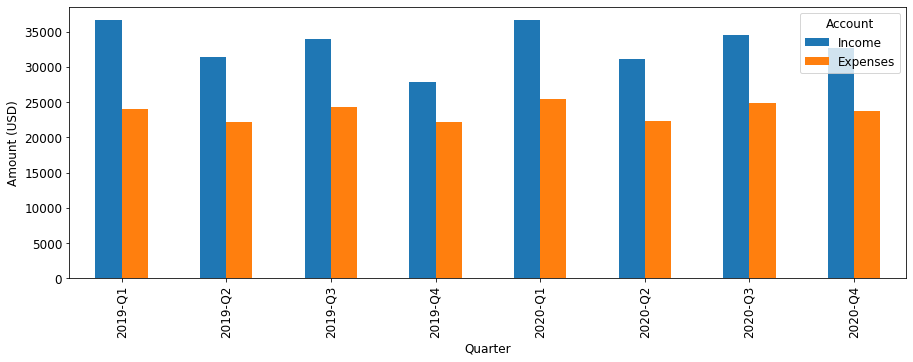

In [32]:
df_L0.columns.name = "Account"
df_L0.plot.bar(x="YearMonth", y=["Income", "Expenses"], xlabel="Quarter", ylabel=df_L0["level_0"][0], rot=90)
plt.show()

## Treemap Plot of Expenses

In [33]:
tot = df_L1.sum(axis=1).to_frame().sort_values(by=0, ascending=False)
tot

0
Account_L0 Account_L1           
Expenses   Taxes       105313.05
           Home         62596.42
...                          ...
           Vacation         0.00
Income     US         -264986.75

[8 rows x 1 columns]

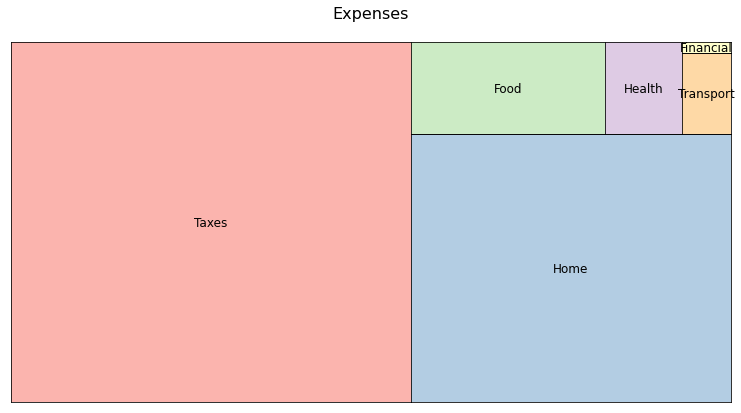

In [34]:
data = tot.loc["Expenses"].sort_values(by=0, ascending=False)
idx = [k[0] != 0 for k in data.values]
values = data.values[idx]
labels = data.index[idx]

width = 1
height = 0.5
values_norm = squarify.normalize_sizes(values, width, height)
rects = squarify.squarify(values_norm, 0, 0, width, height)

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Expenses', x=0.5, y=0.55, fontsize=16)
axes = [fig.add_axes([rect['x'], rect['y'], rect['dx'], rect['dy'], ]) for rect in rects]

for ax, txt, color in zip(axes, labels, plt.cm.Pastel1.colors):
    ax.text(0.5, 0.5, txt, horizontalalignment='center', verticalalignment='center')
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_facecolor(color)    
plt.show()